### Imports

In [70]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Functions

In [170]:
def create_series(N,mode=0):
    series = np.sin((0.1*np.arange(N))**2) 
    if mode==1:
        series += np.random.randn(N)*0.1
    return series

def plot_series(series):
    plt.plot(series)
    plt.show()

def create_dataset(T,N,mode=0,model_type="Linear"):
    series = create_series(N,mode)
    X = []
    Y = []
    for t in range(len(series)-T):
        x = series[t:t+T]
        X.append(x)
        y = series[t+T]
        Y.append(y)
    if model_type=="Linear":
        X = np.array(X).reshape(-1,T)
        Y = np.array(Y).reshape(-1,1)
    elif model_type in ["GRU","LSTM"] :
        X = np.array(X).reshape(-1,T,1)
        Y = np.array(Y).reshape(-1,1)
        
    N = len(X)
    print(N)
    print("X.shape",X.shape,"Y.shape",Y.shape)
    return X,Y    


class SimpleRNN(nn.Module):
    def __init__(self,n_inputs, n_hidden, n_rnnlayers, n_outputs, model_type):
        super(SimpleRNN,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.model_type = model_type
        
        if self.model_type=="GRU":
            self.rnn = nn.GRU(
                input_size = self.D,
                hidden_size = self.M,
                num_layers = self.L,
                batch_first=True
            )
        elif self.model_type=="LSTM":
            self.rnn = nn.LSTM(
                input_size = self.D,
                hidden_size = self.M,
                num_layers = self.L,
                batch_first=True
            )
            
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        if self.model_type=="LSTM":
            c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
            out,_ = self.rnn(X, (h0,c0))
        elif self.model_type=="GRU":
            out,_ = self.rnn(X, h0)
        
        out = self.fc(out[:, -1, :])
        return out


def create_model_and_train(X,Y,T,N,D,M,L,K,n_epochs=100,model_type="Linear"):
    if model_type=="Linear":
        model = nn.Linear(T,1)
    elif model_type=="GRU":
        model = SimpleRNN(n_inputs=D, n_hidden=M, n_rnnlayers=L, n_outputs=K, model_type=model_type)
    elif model_type=="LSTM":
        model = SimpleRNN(n_inputs=D, n_hidden=M, n_rnnlayers=L, n_outputs=K, model_type=model_type)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.05)
    
    # random split is not reasonable in time series
    
    X_train = torch.from_numpy(X[:-N//2].astype(np.float32)).to(device)
    y_train = torch.from_numpy(Y[:-N//2].astype(np.float32)).to(device)
    X_test = torch.from_numpy(X[-N//2:].astype(np.float32)).to(device)
    y_test = torch.from_numpy(Y[-N//2:].astype(np.float32)).to(device)
    
    train_losses = np.zeros(n_epochs)
    test_losses  = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        
        train_losses[it] = loss.item()
        
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        
        if (it+1)%5==0:

            print(f"Epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
        
    return model,train_losses, test_losses, device,X_test,y_test


def plot_metric(data, metric):
    plt.plot(data, label=metric)
    plt.legend()
    plt.show
    
    
def wrong_forcasting(Y,N,X_test,model_type="Linear",T=None):
    validation_target = Y[-N//2:]
    validation_predictions = []
    
    i=0
    while len(validation_predictions)<len(validation_target):
        if model_type=="Linear":
            input_ = X_test[i].reshape(1,-1)
        elif model_type in ["GRU","LSTM"]:
            input_ = X_test[i].reshape(1,T,-1)
            
        p = model(input_)[0,0].item()
        i+=1
        validation_predictions.append(p)
        
    return validation_predictions,validation_target

def correct_forcasting(Y,N,X_test,model_type="Linear",T=None):
    validation_target = Y[-N//2:]
    validation_predictions = []
    
    if model_type=="Linear":
        last_x = torch.from_numpy(X[-N//2].astype(np.float32))
    elif model_type in ["GRU","LSTM"]:
        last_x = X_test[0].view(T)
            
    while len(validation_predictions)<len(validation_target):
        if model_type=="Linear":
            input_ = last_x.view(1,-1)
        elif model_type in ["GRU","LSTM"]:
            input_ = last_x.view(1,T,-1)
            
        p = model(input_)
        
        validation_predictions.append(p[0,0].item())
        
        last_x = torch.cat((last_x[1:],p[0]))
        
    return validation_predictions,validation_target

### Create data

In [171]:
series = create_series(N=400,mode=0)

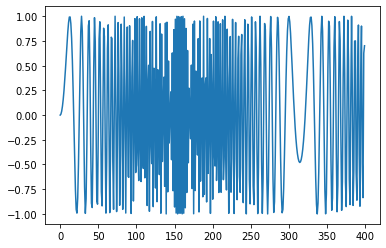

In [172]:
plot_series(series)

In [173]:
T=10
D=1
N=400
model_type="LSTM"
# check with GRU and Linear too
X , Y = create_dataset(T=T,N=N,mode=0,model_type=model_type)
N = len(X)

390
X.shape (390, 10, 1) Y.shape (390, 1)


In [174]:
# plot_series(X)

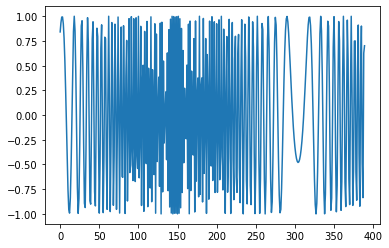

In [175]:
plot_series(Y)

### Create and train model

In [176]:
M=10
K=1
L=1

In [177]:
model,train_losses, test_losses, device, X_test, y_test = create_model_and_train(X,Y,T=T,N=N,D=D,M=M,L=L,K=K,n_epochs=200,model_type=model_type)

cpu
Epoch 5/200, Train Loss: 0.5123, Test Loss: 0.5319
Epoch 10/200, Train Loss: 0.4987, Test Loss: 0.6149
Epoch 15/200, Train Loss: 0.4945, Test Loss: 0.6238
Epoch 20/200, Train Loss: 0.4869, Test Loss: 0.6041
Epoch 25/200, Train Loss: 0.4677, Test Loss: 0.5796
Epoch 30/200, Train Loss: 0.3804, Test Loss: 0.4272
Epoch 35/200, Train Loss: 0.2094, Test Loss: 0.2932
Epoch 40/200, Train Loss: 0.0849, Test Loss: 0.2257
Epoch 45/200, Train Loss: 0.0568, Test Loss: 0.1490
Epoch 50/200, Train Loss: 0.0277, Test Loss: 0.0936
Epoch 55/200, Train Loss: 0.0240, Test Loss: 0.0886
Epoch 60/200, Train Loss: 0.0201, Test Loss: 0.0666
Epoch 65/200, Train Loss: 0.0144, Test Loss: 0.0777
Epoch 70/200, Train Loss: 0.0121, Test Loss: 0.0836
Epoch 75/200, Train Loss: 0.0104, Test Loss: 0.0806
Epoch 80/200, Train Loss: 0.0086, Test Loss: 0.0728
Epoch 85/200, Train Loss: 0.0077, Test Loss: 0.0740
Epoch 90/200, Train Loss: 0.0067, Test Loss: 0.0755
Epoch 95/200, Train Loss: 0.0060, Test Loss: 0.0748
Epoch 100

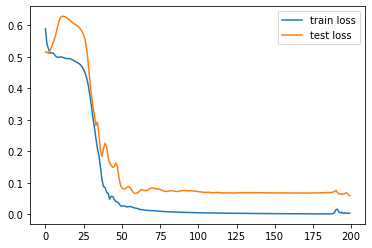

In [178]:
plot_metric(train_losses, "train loss")
plot_metric(test_losses, "test loss")

### Wrong forecasintg

In [179]:
validation_predictions,validation_target = wrong_forcasting(Y,N,X_test,model_type=model_type,T=T)

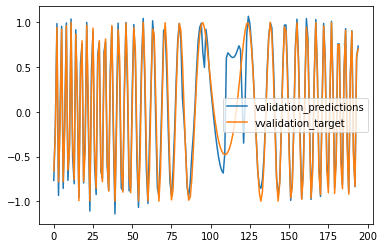

In [180]:
plot_metric(validation_predictions, "validation_predictions")
plot_metric(validation_target, "vvalidation_target")

### Correct forecasting

In [181]:
validation_predictions,validation_target = correct_forcasting(Y,N,X_test,model_type=model_type,T=T)

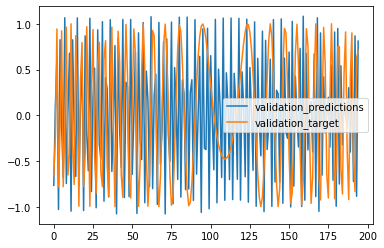

In [182]:
plot_metric(validation_predictions, "validation_predictions")
plot_metric(validation_target, "validation_target")